In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Prepare training dataset

In [ ]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 393102609.08it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 109328243.52it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 161209589.66it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20639792.81it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [ ]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:14,  8.24it/s]                         


Epoch 1 of 100
Generator loss: 1.93762076, Discriminator loss: 1.21614969


118it [00:14,  8.20it/s]                         


Epoch 2 of 100
Generator loss: 2.46628761, Discriminator loss: 0.84276068


118it [00:14,  8.19it/s]                         


Epoch 3 of 100
Generator loss: 1.44535220, Discriminator loss: 1.20244706


118it [00:14,  8.10it/s]                         


Epoch 4 of 100
Generator loss: 2.04712749, Discriminator loss: 1.07559586


118it [00:14,  8.06it/s]                         


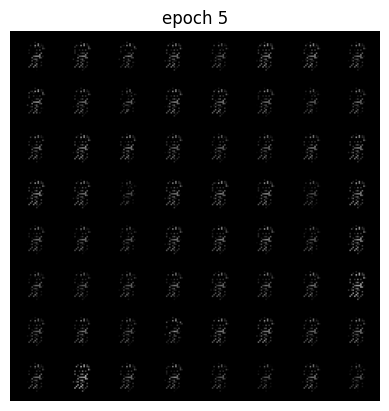

Epoch 5 of 100
Generator loss: 1.44823277, Discriminator loss: 1.28262830


118it [00:14,  8.12it/s]                         


Epoch 6 of 100
Generator loss: 1.29228163, Discriminator loss: 1.33346677


118it [00:14,  8.06it/s]                         


Epoch 7 of 100
Generator loss: 1.15299213, Discriminator loss: 1.24800682


118it [00:14,  8.05it/s]                         


Epoch 8 of 100
Generator loss: 0.87196994, Discriminator loss: 1.34494901


118it [00:14,  8.07it/s]                         


Epoch 9 of 100
Generator loss: 1.14958286, Discriminator loss: 1.37070441


118it [00:14,  8.11it/s]                         


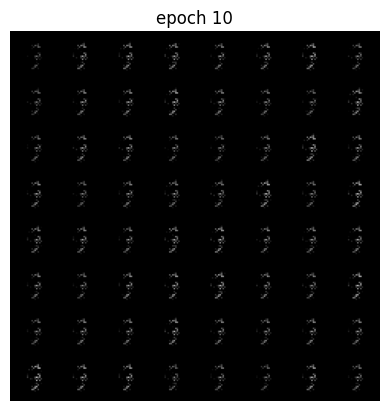

Epoch 10 of 100
Generator loss: 1.07888842, Discriminator loss: 1.34738421


118it [00:14,  8.09it/s]                         


Epoch 11 of 100
Generator loss: 1.02838850, Discriminator loss: 1.27668536


118it [00:14,  8.05it/s]                         


Epoch 12 of 100
Generator loss: 1.10247064, Discriminator loss: 1.32628775


118it [00:14,  8.13it/s]                         


Epoch 13 of 100
Generator loss: 1.11622560, Discriminator loss: 1.21160173


118it [00:14,  8.05it/s]                         


Epoch 14 of 100
Generator loss: 0.77789479, Discriminator loss: 1.40519786


118it [00:14,  8.08it/s]                         


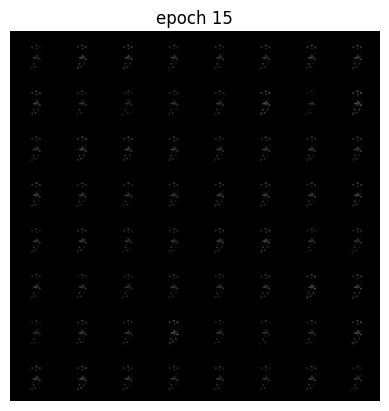

Epoch 15 of 100
Generator loss: 0.97689253, Discriminator loss: 1.27312613


118it [00:14,  8.13it/s]                         


Epoch 16 of 100
Generator loss: 0.95784020, Discriminator loss: 1.18336439


118it [00:14,  8.06it/s]                         


Epoch 17 of 100
Generator loss: 0.87637711, Discriminator loss: 1.32088256


118it [00:14,  8.12it/s]                         


Epoch 18 of 100
Generator loss: 1.50734675, Discriminator loss: 1.11337245


118it [00:14,  8.07it/s]                         


Epoch 19 of 100
Generator loss: 1.22266269, Discriminator loss: 1.07016957


118it [00:14,  8.13it/s]                         


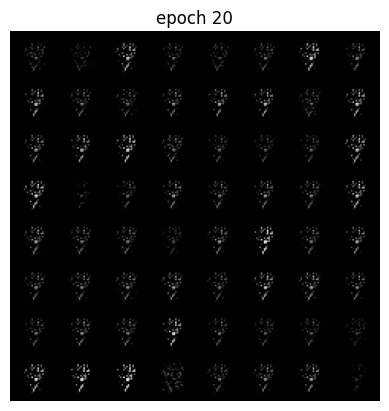

Epoch 20 of 100
Generator loss: 1.49350083, Discriminator loss: 1.09918821


118it [00:14,  8.02it/s]                         


Epoch 21 of 100
Generator loss: 1.46132159, Discriminator loss: 0.95499468


118it [00:14,  8.04it/s]                         


Epoch 22 of 100
Generator loss: 1.46357346, Discriminator loss: 1.08850420


118it [00:14,  8.12it/s]                         


Epoch 23 of 100
Generator loss: 1.86492455, Discriminator loss: 0.94202608


118it [00:14,  8.04it/s]                         


Epoch 24 of 100
Generator loss: 1.60056257, Discriminator loss: 1.08050764


118it [00:14,  8.03it/s]                         


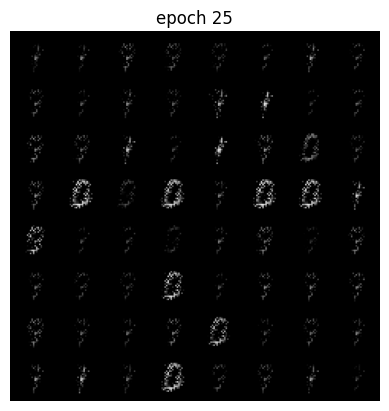

Epoch 25 of 100
Generator loss: 1.66687322, Discriminator loss: 0.83071995


118it [00:14,  8.01it/s]                         


Epoch 26 of 100
Generator loss: 2.11499953, Discriminator loss: 0.78545558


118it [00:14,  8.05it/s]                         


Epoch 27 of 100
Generator loss: 2.26443434, Discriminator loss: 0.59156716


118it [00:14,  8.01it/s]                         


Epoch 28 of 100
Generator loss: 2.10806274, Discriminator loss: 0.66144675


118it [00:14,  8.04it/s]                         


Epoch 29 of 100
Generator loss: 2.04014277, Discriminator loss: 0.86780852


118it [00:14,  8.07it/s]                         


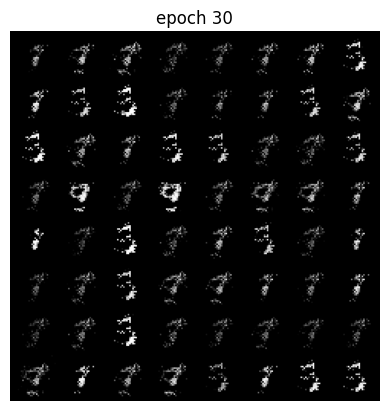

Epoch 30 of 100
Generator loss: 1.83648288, Discriminator loss: 0.81708711


118it [00:14,  8.05it/s]                         


Epoch 31 of 100
Generator loss: 1.63193488, Discriminator loss: 0.76806784


118it [00:14,  8.01it/s]                         


Epoch 32 of 100
Generator loss: 1.90308523, Discriminator loss: 0.70393610


118it [00:14,  8.11it/s]                         


Epoch 33 of 100
Generator loss: 1.88012195, Discriminator loss: 0.81602764


118it [00:14,  8.09it/s]                         


Epoch 34 of 100
Generator loss: 1.57407475, Discriminator loss: 0.95073169


118it [00:14,  8.08it/s]                         


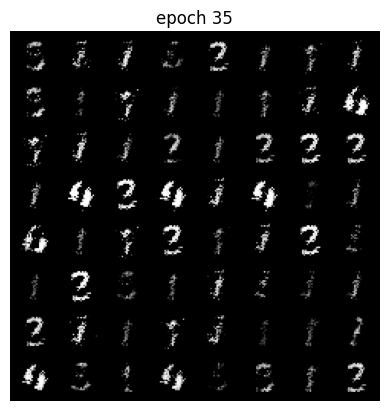

Epoch 35 of 100
Generator loss: 1.74327469, Discriminator loss: 0.82311791


118it [00:14,  8.04it/s]                         


Epoch 36 of 100
Generator loss: 1.39122999, Discriminator loss: 0.99453211


118it [00:14,  8.03it/s]                         


Epoch 37 of 100
Generator loss: 1.46410692, Discriminator loss: 0.91765434


118it [00:14,  8.07it/s]                         


Epoch 38 of 100
Generator loss: 1.52265787, Discriminator loss: 0.91436297


118it [00:14,  8.01it/s]                         


Epoch 39 of 100
Generator loss: 1.56840956, Discriminator loss: 0.85875291


118it [00:14,  8.11it/s]                         


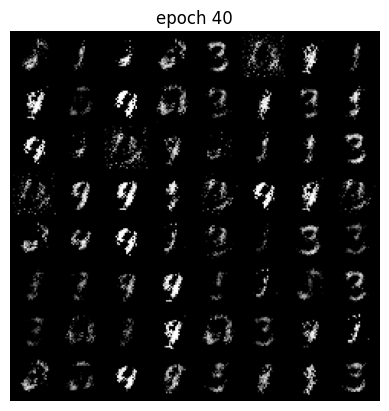

Epoch 40 of 100
Generator loss: 1.56442404, Discriminator loss: 0.93173611


118it [00:14,  7.99it/s]                         


Epoch 41 of 100
Generator loss: 1.44453812, Discriminator loss: 1.01127195


118it [00:14,  8.00it/s]                         


Epoch 42 of 100
Generator loss: 1.57144189, Discriminator loss: 0.90768224


118it [00:14,  8.07it/s]                         


Epoch 43 of 100
Generator loss: 1.60927153, Discriminator loss: 0.85290152


118it [00:14,  8.00it/s]                         


Epoch 44 of 100
Generator loss: 1.71623611, Discriminator loss: 0.87932825


118it [00:14,  7.98it/s]                         


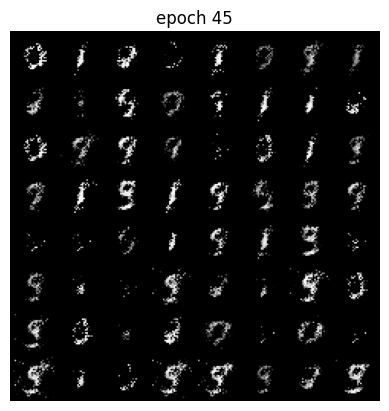

Epoch 45 of 100
Generator loss: 1.91940725, Discriminator loss: 0.77121204


118it [00:14,  8.02it/s]                         


Epoch 46 of 100
Generator loss: 1.60849917, Discriminator loss: 0.84558827


118it [00:14,  7.99it/s]                         


Epoch 47 of 100
Generator loss: 1.74277580, Discriminator loss: 0.84911209


118it [00:14,  8.07it/s]                         


Epoch 48 of 100
Generator loss: 1.75999761, Discriminator loss: 0.81559479


118it [00:14,  8.03it/s]                         


Epoch 49 of 100
Generator loss: 1.93510747, Discriminator loss: 0.73624092


118it [00:14,  8.03it/s]                         


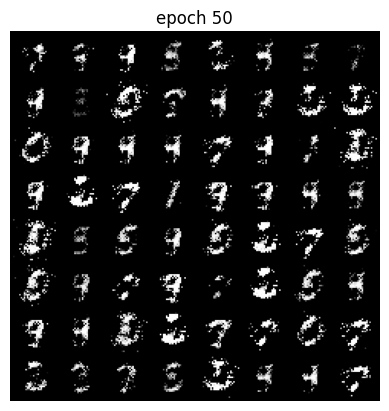

Epoch 50 of 100
Generator loss: 1.84407592, Discriminator loss: 0.84850734


118it [00:14,  7.89it/s]                         


Epoch 51 of 100
Generator loss: 1.82402861, Discriminator loss: 0.82402438


118it [00:14,  8.03it/s]                         


Epoch 52 of 100
Generator loss: 1.87883544, Discriminator loss: 0.85258949


118it [00:14,  8.07it/s]                         


Epoch 53 of 100
Generator loss: 1.79124796, Discriminator loss: 0.82766962


118it [00:14,  8.05it/s]                         


Epoch 54 of 100
Generator loss: 1.92740440, Discriminator loss: 0.85523540


118it [00:14,  7.94it/s]                         


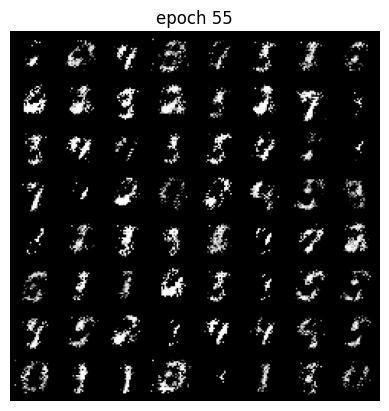

Epoch 55 of 100
Generator loss: 1.80789685, Discriminator loss: 0.81070614


118it [00:14,  7.95it/s]                         


Epoch 56 of 100
Generator loss: 1.77383173, Discriminator loss: 0.91590816


118it [00:14,  8.07it/s]                         


Epoch 57 of 100
Generator loss: 1.81223285, Discriminator loss: 0.84016120


118it [00:14,  7.96it/s]                         


Epoch 58 of 100
Generator loss: 1.90494704, Discriminator loss: 0.82848525


118it [00:14,  7.99it/s]                         


Epoch 59 of 100
Generator loss: 1.95715749, Discriminator loss: 0.75818890


118it [00:14,  8.04it/s]                         


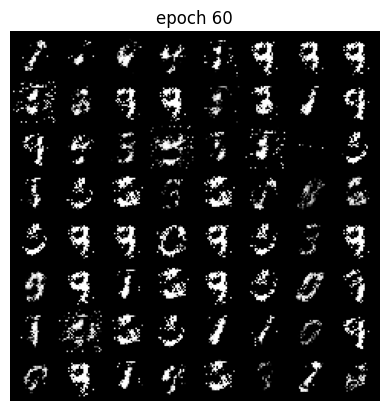

Epoch 60 of 100
Generator loss: 2.06349874, Discriminator loss: 0.77673793


118it [00:14,  7.97it/s]                         


Epoch 61 of 100
Generator loss: 2.35703659, Discriminator loss: 0.67560625


118it [00:14,  7.93it/s]                         


Epoch 62 of 100
Generator loss: 2.53087735, Discriminator loss: 0.67250645


118it [00:14,  8.08it/s]                         


Epoch 63 of 100
Generator loss: 2.74144363, Discriminator loss: 0.63947988


118it [00:14,  7.98it/s]                         


Epoch 64 of 100
Generator loss: 3.19447851, Discriminator loss: 0.54280013


118it [00:14,  7.94it/s]                         


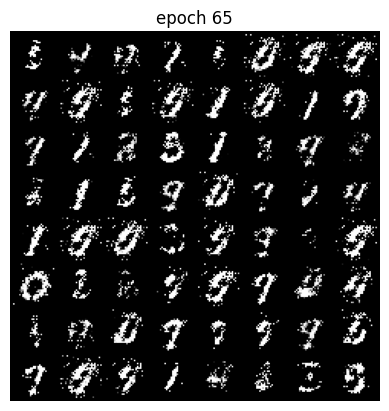

Epoch 65 of 100
Generator loss: 3.36277342, Discriminator loss: 0.51839906


118it [00:14,  7.96it/s]                         


Epoch 66 of 100
Generator loss: 2.97466803, Discriminator loss: 0.58237660


118it [00:14,  8.00it/s]                         


Epoch 67 of 100
Generator loss: 2.97567272, Discriminator loss: 0.59981304


118it [00:14,  8.04it/s]                         


Epoch 68 of 100
Generator loss: 3.62113810, Discriminator loss: 0.41623813


118it [00:14,  8.02it/s]                         


Epoch 69 of 100
Generator loss: 3.74415183, Discriminator loss: 0.41238856


118it [00:14,  8.05it/s]                         


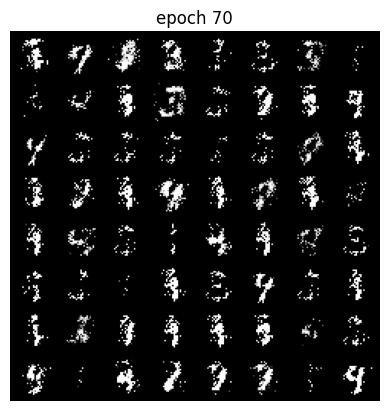

Epoch 70 of 100
Generator loss: 4.33097649, Discriminator loss: 0.35439986


118it [00:14,  7.90it/s]                         


Epoch 71 of 100
Generator loss: 4.40914774, Discriminator loss: 0.34123468


118it [00:14,  7.96it/s]                         


Epoch 72 of 100
Generator loss: 4.39530802, Discriminator loss: 0.33202559


118it [00:14,  8.10it/s]                         


Epoch 73 of 100
Generator loss: 4.48555660, Discriminator loss: 0.32849449


118it [00:14,  8.00it/s]                         


Epoch 74 of 100
Generator loss: 4.55571890, Discriminator loss: 0.33352673


118it [00:14,  7.99it/s]                         


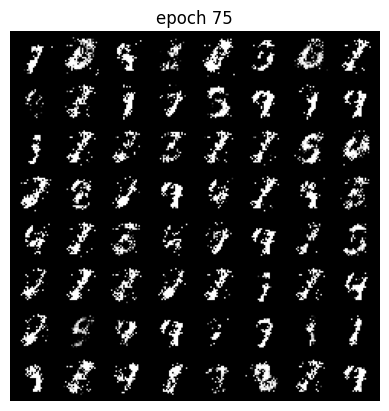

Epoch 75 of 100
Generator loss: 4.19904518, Discriminator loss: 0.33761159


118it [00:14,  8.01it/s]                         


Epoch 76 of 100
Generator loss: 4.31200266, Discriminator loss: 0.36978608


118it [00:14,  8.05it/s]                         


Epoch 77 of 100
Generator loss: 4.18287945, Discriminator loss: 0.32765409


118it [00:14,  8.02it/s]                         


Epoch 78 of 100
Generator loss: 4.50558519, Discriminator loss: 0.28283364


118it [00:14,  8.04it/s]                         


Epoch 79 of 100
Generator loss: 4.56925106, Discriminator loss: 0.30780196


118it [00:14,  8.07it/s]                         


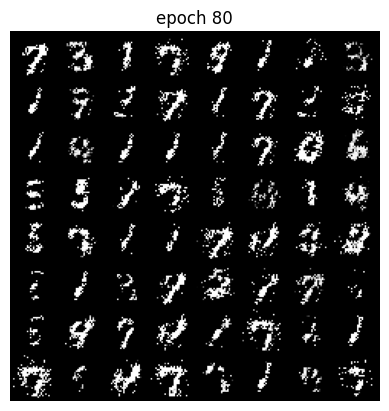

Epoch 80 of 100
Generator loss: 4.61630106, Discriminator loss: 0.32971519


118it [00:14,  7.94it/s]                         


Epoch 81 of 100
Generator loss: 4.26807690, Discriminator loss: 0.35998479


118it [00:14,  7.98it/s]                         


Epoch 82 of 100
Generator loss: 3.98985672, Discriminator loss: 0.39443395


118it [00:14,  8.08it/s]                         


Epoch 83 of 100
Generator loss: 3.56330943, Discriminator loss: 0.45152968


118it [00:14,  8.00it/s]                         


Epoch 84 of 100
Generator loss: 3.68163037, Discriminator loss: 0.42785114


118it [00:14,  7.95it/s]                         


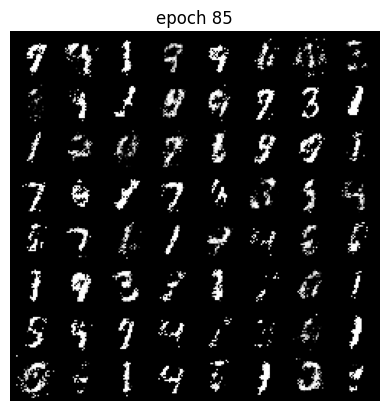

Epoch 85 of 100
Generator loss: 3.11015105, Discriminator loss: 0.51887733


118it [00:14,  7.96it/s]                         


Epoch 86 of 100
Generator loss: 2.98211884, Discriminator loss: 0.54613358


118it [00:14,  8.01it/s]                         


Epoch 87 of 100
Generator loss: 3.16764903, Discriminator loss: 0.54130900


118it [00:14,  7.88it/s]                         


Epoch 88 of 100
Generator loss: 3.06932425, Discriminator loss: 0.53909349


118it [00:14,  8.00it/s]                         


Epoch 89 of 100
Generator loss: 2.77375150, Discriminator loss: 0.59897655


118it [00:14,  8.05it/s]                         


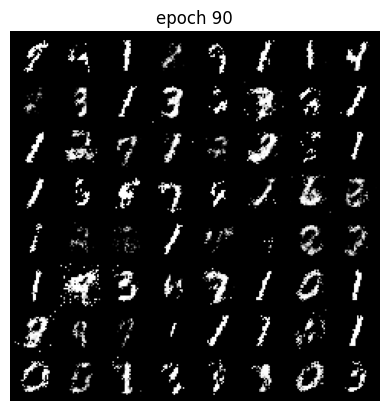

Epoch 90 of 100
Generator loss: 2.70674491, Discriminator loss: 0.60979784


118it [00:15,  7.87it/s]                         


Epoch 91 of 100
Generator loss: 2.69177175, Discriminator loss: 0.64842856


118it [00:14,  8.02it/s]                         


Epoch 92 of 100
Generator loss: 2.45966744, Discriminator loss: 0.69770086


118it [00:14,  8.00it/s]                         


Epoch 93 of 100
Generator loss: 2.32052112, Discriminator loss: 0.70114517


118it [00:14,  7.92it/s]                         


Epoch 94 of 100
Generator loss: 2.27776933, Discriminator loss: 0.70771885


118it [00:14,  7.96it/s]                         


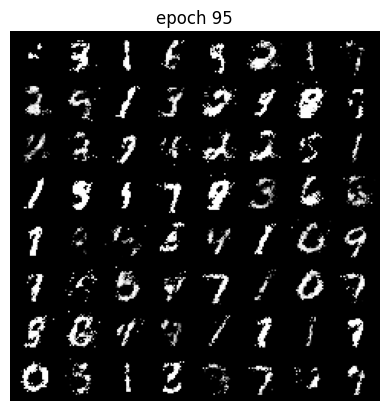

Epoch 95 of 100
Generator loss: 2.11940169, Discriminator loss: 0.77003580


118it [00:14,  7.94it/s]                         


Epoch 96 of 100
Generator loss: 1.95780921, Discriminator loss: 0.79701614


118it [00:14,  8.04it/s]                         


Epoch 97 of 100
Generator loss: 2.01418090, Discriminator loss: 0.82398349


118it [00:14,  7.96it/s]                         


Epoch 98 of 100
Generator loss: 1.94100559, Discriminator loss: 0.79370564


118it [00:14,  7.97it/s]                         


Epoch 99 of 100
Generator loss: 2.10323477, Discriminator loss: 0.76537299


118it [00:14,  8.03it/s]                         


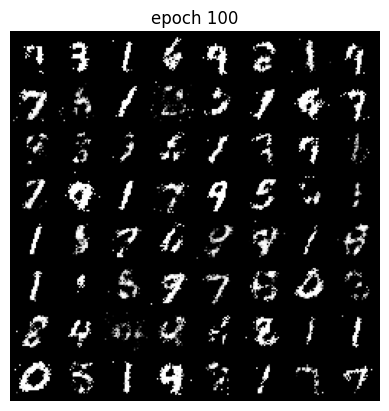

Epoch 100 of 100
Generator loss: 2.02937508, Discriminator loss: 0.75804925


In [ ]:
from torch.nn.modules import loss
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

  loss = criterion(output,true_label)
  return loss
    
    ######################################
    
def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
  # print(len(output),len(true_label))
  loss = criterion(output,true_label)
  # print(1)
  return loss
    
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 

      ### Discriminator ###
      img,_ = data
      real_img = img.view(img.shape[0],-1).to(device)

      real_labels = label_real(img.shape[0])
      fake_labels = label_fake(sample_size)

      real_output = discriminator(real_img).to(device)
      loss_d_real = discriminator_loss(real_output,real_labels)

      fake_img = generator(noise).detach()
      fake_output = discriminator(fake_img).to(device)
      loss_d_fake = discriminator_loss(fake_output,fake_labels)

      d_loss = loss_d_real+loss_d_fake
      optim_d.zero_grad()
      d_loss.backward()
      optim_d.step()

      ### Generator ###
      fake_img = generator(noise).to(device)
      fake_output = discriminator(fake_img).to(device)
      g_loss = generator_loss(fake_output,label_real(sample_size))
      optim_g.zero_grad()
      g_loss.backward()
      optim_g.step()


      loss_g += g_loss
      loss_d += d_loss

        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'drive/MyDrive/CS760/outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('drive/MyDrive/CS760/outputs/generator_images.gif', imgs)

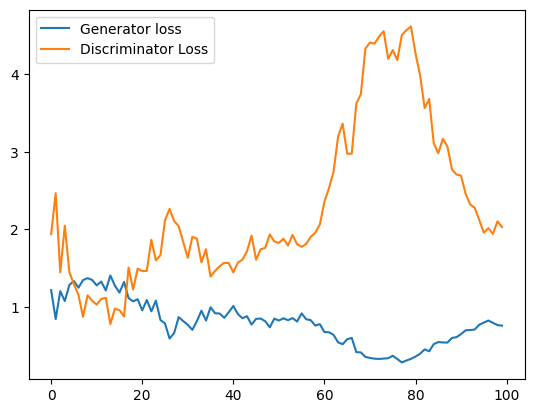

In [ ]:
d_list = [tensor.cpu().detach().numpy() for tensor in losses_d]
g_list = [tensor.cpu().detach().numpy() for tensor in losses_g]
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(d_list, label='Generator loss')
plt.plot(g_list, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')